In [1]:
%load_ext rpy2.ipython

In [2]:
%%R

#install.packages("tibble")
#install.packages("dplyr")
#install.packages(ggplot2)
#install.packages("caret")
#install.packages("glmnet")

library(tibble)
library(dplyr)
library(ggplot2)
library(caret)
library(pROC)
library(ROSE)
library(glmnet)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: lattice
Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var

Loaded ROSE 0.0-4

Loading required package: Matrix
Loaded glmnet 4.1-8
In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


In [3]:
%%R

binary_driving_mode <- function (df_chassis) {
    result <- ifelse(df_chassis$drivingMode == "COMPLETE_AUTO_DRIVE", 1, 0)

    return(result)
}


merge_chassis_pose <- function (df_chassis, df_pose) {
    
    
    df_chassis <- df_chassis[order(df_chassis$time), ]
    df_pose <- df_pose[order(df_pose$time), ]
    
    #make sure data is sorted by time fist

    chassis_time_arr <- df_chassis$time
    pose_time_arr <- df_pose$time

    matched_vector <- c()

    for (chassis_time in chassis_time_arr) {
        abs_time_diff_arr <- abs(pose_time_arr - chassis_time)

        min_index <-  which(abs_time_diff_arr == min(abs_time_diff_arr))
        
        matched_vector <-  c(matched_vector, pose_time_arr[min_index])
    }



    #df_chassis$matched <- df_pose$time[which(abs(pose_time_arr - df_chassis$time) == min(abs(pose_time_arr - df_chassis$time)))]
    df_chassis$matched <-  matched_vector
    df_pose$matched <-  df_pose$time


    return (list(df_chassis = df_chassis, df_pose = df_pose))


}

latlongStdDev <- function(df_pose){
    x <- df_pose["latitudeStdDev"]
    y <- df_pose["longitudeStdDev"]
        r <- sqrt(x^2 + y^2)

    return(r)

}

In [4]:
%%R
# Defining GMIDs for Red Routes
# Am creating a list of GMIDs for processing
green_route_gmIDs  <- c(
    '3ec95686-f053-11ee-b988-fb353e7798cd',
'b31aca98-cb95-11ee-909c-e1dc60cf66f9',
'25e27b86-f06a-11ee-b9a3-fb353e7798cd',
'bf9157f0-f16b-11ee-ba9e-fb353e7798cd',
'51b74168-f19d-11ee-babf-fb353e7798cd',
'de493be2-f10f-11ee-ba4b-fb353e7798cd',
'ece2a8be-f047-11ee-b97d-fb353e7798cd',
'044d976e-f0e5-11ee-ba20-fb353e7798cd',
'98692fde-f1a4-11ee-bac6-fb353e7798cd',
'5afabc8c-f035-11ee-b966-fb353e7798cd',
'072ef896-cbac-11ee-909c-e1dc60cf66f9',
'c59a54e0-f179-11ee-baab-fb353e7798cd',
'bbbd0cc6-f0dc-11ee-ba1e-fb353e7798cd',
'ba87f3ec-f07e-11ee-b9b4-fb353e7798cd',
'96ceec56-f1cf-11ee-bae4-fb353e7798cd',
'40706f50-f03b-11ee-b96e-fb353e7798cd',
'f570c51c-f15d-11ee-ba91-fb353e7798cd',
'f12112ba-f1c0-11ee-bada-fb353e7798cd',
'961fd9cc-f103-11ee-ba3f-fb353e7798cd',
'5f7ce340-f1c8-11ee-bae0-fb353e7798cd',
'cf7148d8-f058-11ee-b98a-fb353e7798cd',
'848e44a6-f134-11ee-ba6d-fb353e7798cd',
'3a7dc9a6-f042-11ee-b974-fb353e7798cd',
'c9be2042-f0de-11ee-ba1e-fb353e7798cd',
'9736e77c-f187-11ee-bab6-fb353e7798cd',
'5fc763f6-f1ab-11ee-bacd-fb353e7798cd',
'4c88757c-f157-11ee-ba89-fb353e7798cd',
'a231c0b0-f142-11ee-ba76-fb353e7798cd',
'53fad09e-f0f7-11ee-ba2f-fb353e7798cd',
'5c7a9ab2-f13b-11ee-ba72-fb353e7798cd',
'4cf81634-f238-11ee-bb34-fb353e7798cd',
'a08a8c7e-f1fb-11ee-bb05-fb353e7798cd',
'3ed4aa16-f1d6-11ee-bae6-fb353e7798cd',
'25135418-f250-11ee-bb4a-fb353e7798cd',
'c1b320e2-f079-11ee-b9b0-fb353e7798cd',
'43abeb00-f206-11ee-bb07-fb353e7798cd',
'fe0395f0-f1ea-11ee-baf9-fb353e7798cd',
'3d8020aa-cb7f-11ee-909c-e1dc60cf66f9',
'14b6bc9c-f064-11ee-b998-fb353e7798cd',
'870cfd32-f1b9-11ee-bad5-fb353e7798cd',
'c2f54552-f06f-11ee-b9a9-fb353e7798cd',
'dea29156-f123-11ee-ba5d-fb353e7798cd',
'3c415ade-d353-11ee-b437-336917683bb8',
'a901fe40-f0fd-11ee-ba39-fb353e7798cd',
'c4146d46-f074-11ee-b9ac-fb353e7798cd',
'de226278-f25a-11ee-bb4e-fb353e7798cd',
'd7cb9c92-f164-11ee-ba97-fb353e7798cd',
'88b0613a-d35d-11ee-b437-336917683bb8',
'c4fca7bc-f18e-11ee-bab8-fb353e7798cd',
'ed352100-cba0-11ee-909c-e1dc60cf66f9',
'cbdc93f4-f255-11ee-bb4e-fb353e7798cd',
'8e5c4fc2-f149-11ee-ba7f-fb353e7798cd',
'bb4d37d4-f109-11ee-ba46-fb353e7798cd',
'236836f6-f1dd-11ee-bae8-fb353e7798cd',
'7948628e-f20b-11ee-bb0f-fb353e7798cd',
'c14299be-f180-11ee-bab0-fb353e7798cd',
'73bc30cc-f150-11ee-ba84-fb353e7798cd',
'7e3d64da-f12d-11ee-ba68-fb353e7798cd',
'837fc882-cb5a-11ee-909c-e1dc60cf66f9',
'f8fd0fd8-f243-11ee-bb3f-fb353e7798cd',
'58d78342-f24a-11ee-bb45-fb353e7798cd',
'8adb6498-f04d-11ee-b981-fb353e7798cd',
'271fee10-cb8b-11ee-909c-e1dc60cf66f9',
'99b9f446-f1b2-11ee-bad3-fb353e7798cd',
'5774dcde-f196-11ee-babe-fb353e7798cd',
'1c74d294-f1e4-11ee-baf0-fb353e7798cd',
'0f3cdf60-f1f6-11ee-bb00-fb353e7798cd',
'8b0593cc-cb4e-11ee-909c-e1dc60cf66f9',
'a6539bd2-cb72-11ee-909c-e1dc60cf66f9'
)    

In [5]:
%%R
# Initialize an empty tibble
df_merged <- tibble()

# Loop through each gmID
for (id in green_route_gmIDs) {
  print(id)
  
  # Update the file paths with the correct full paths
  temp_chassis_path <- sprintf(
    "/home/gampadu_linux/Desktop/TDMprivate/data/%s/_apollo_canbus_chassis/%s_apollo_canbus_chassis.csv",
    id, id
  )
  temp_pose_path <- sprintf(
    "/home/gampadu_linux/Desktop/TDMprivate/data/%s/_apollo_sensor_gnss_best_pose/%s_apollo_sensor_gnss_best_pose.csv",
    id, id
  )

  # Check if the files exist
  if (file.exists(temp_chassis_path) && file.exists(temp_pose_path)) {
    # Read the files
    temp_chassis <- as_tibble(read.csv(temp_chassis_path))
    temp_pose <- as_tibble(read.csv(temp_pose_path))
    
    # Process the data
    r <- latlongStdDev(temp_pose)
    temp_pose["latlongStdDev"] <- r
    
    results <- merge_chassis_pose(temp_chassis, temp_pose)
    result_full <- full_join(results$df_chassis, results$df_pose, by = "matched")
    
    # Add binary driving mode
    result_full$binaryDrivingMode <- binary_driving_mode(result_full)
    
    # Append to df_merged
    df_merged <- bind_rows(df_merged, result_full)
  } else {
    warning(sprintf("Files not found for gmID: %s", id))
  }
}

print("Done loading data")

[1] "3ec95686-f053-11ee-b988-fb353e7798cd"
[1] "b31aca98-cb95-11ee-909c-e1dc60cf66f9"
[1] "25e27b86-f06a-11ee-b9a3-fb353e7798cd"
[1] "bf9157f0-f16b-11ee-ba9e-fb353e7798cd"
[1] "51b74168-f19d-11ee-babf-fb353e7798cd"
[1] "de493be2-f10f-11ee-ba4b-fb353e7798cd"
[1] "ece2a8be-f047-11ee-b97d-fb353e7798cd"
[1] "044d976e-f0e5-11ee-ba20-fb353e7798cd"
[1] "98692fde-f1a4-11ee-bac6-fb353e7798cd"
[1] "5afabc8c-f035-11ee-b966-fb353e7798cd"
[1] "072ef896-cbac-11ee-909c-e1dc60cf66f9"
[1] "c59a54e0-f179-11ee-baab-fb353e7798cd"
[1] "bbbd0cc6-f0dc-11ee-ba1e-fb353e7798cd"
[1] "ba87f3ec-f07e-11ee-b9b4-fb353e7798cd"
[1] "96ceec56-f1cf-11ee-bae4-fb353e7798cd"
[1] "40706f50-f03b-11ee-b96e-fb353e7798cd"
[1] "f570c51c-f15d-11ee-ba91-fb353e7798cd"
[1] "f12112ba-f1c0-11ee-bada-fb353e7798cd"
[1] "961fd9cc-f103-11ee-ba3f-fb353e7798cd"
[1] "5f7ce340-f1c8-11ee-bae0-fb353e7798cd"
[1] "cf7148d8-f058-11ee-b98a-fb353e7798cd"
[1] "848e44a6-f134-11ee-ba6d-fb353e7798cd"
[1] "3a7dc9a6-f042-11ee-b974-fb353e7798cd"
[1] "c9be20

In [6]:
%%R
# Load required library
library(dplyr)

# Split GMIDs into Training and Testing Sets
training_gmIDs <- green_route_gmIDs[1:64]  # First 64 GMIDs (80%)
testing_gmIDs <- green_route_gmIDs[65:69] # Last 5 GMIDs 

# Filter df_merged for training and testing data based on GMIDs
train_data <- df_merged %>% filter(groupMetadataID.x %in% training_gmIDs)
test_data <- df_merged %>% filter(groupMetadataID.x %in% testing_gmIDs)

# Check the number of rows in each dataset
print(paste("Training data rows:", nrow(train_data)))
print(paste("Testing data rows:", nrow(test_data)))

# Verify if test_data is not empty
if (nrow(test_data) == 0) {
  print("Error: test_data is empty. Check GMID filtering.")
}

[1] "Training data rows: 1722824"
[1] "Testing data rows: 163486"


In [7]:
%%R
training_gmIDs

 [1] "3ec95686-f053-11ee-b988-fb353e7798cd"
 [2] "b31aca98-cb95-11ee-909c-e1dc60cf66f9"
 [3] "25e27b86-f06a-11ee-b9a3-fb353e7798cd"
 [4] "bf9157f0-f16b-11ee-ba9e-fb353e7798cd"
 [5] "51b74168-f19d-11ee-babf-fb353e7798cd"
 [6] "de493be2-f10f-11ee-ba4b-fb353e7798cd"
 [7] "ece2a8be-f047-11ee-b97d-fb353e7798cd"
 [8] "044d976e-f0e5-11ee-ba20-fb353e7798cd"
 [9] "98692fde-f1a4-11ee-bac6-fb353e7798cd"
[10] "5afabc8c-f035-11ee-b966-fb353e7798cd"
[11] "072ef896-cbac-11ee-909c-e1dc60cf66f9"
[12] "c59a54e0-f179-11ee-baab-fb353e7798cd"
[13] "bbbd0cc6-f0dc-11ee-ba1e-fb353e7798cd"
[14] "ba87f3ec-f07e-11ee-b9b4-fb353e7798cd"
[15] "96ceec56-f1cf-11ee-bae4-fb353e7798cd"
[16] "40706f50-f03b-11ee-b96e-fb353e7798cd"
[17] "f570c51c-f15d-11ee-ba91-fb353e7798cd"
[18] "f12112ba-f1c0-11ee-bada-fb353e7798cd"
[19] "961fd9cc-f103-11ee-ba3f-fb353e7798cd"
[20] "5f7ce340-f1c8-11ee-bae0-fb353e7798cd"
[21] "cf7148d8-f058-11ee-b98a-fb353e7798cd"
[22] "848e44a6-f134-11ee-ba6d-fb353e7798cd"
[23] "3a7dc9a6-f042-11ee-b974-fb

In [8]:
%%R
testing_gmIDs

[1] "5774dcde-f196-11ee-babe-fb353e7798cd"
[2] "1c74d294-f1e4-11ee-baf0-fb353e7798cd"
[3] "0f3cdf60-f1f6-11ee-bb00-fb353e7798cd"
[4] "8b0593cc-cb4e-11ee-909c-e1dc60cf66f9"
[5] "a6539bd2-cb72-11ee-909c-e1dc60cf66f9"


In [9]:
%%R
# Train a Logistic Regression Model
model <- glm(
  binaryDrivingMode ~ speedMps + throttlePercentage + brakePercentage + steeringPercentage + latlongStdDev,
  data = train_data,
  family = binomial
)

summary(model)


Call:
glm(formula = binaryDrivingMode ~ speedMps + throttlePercentage + 
    brakePercentage + steeringPercentage + latlongStdDev, family = binomial, 
    data = train_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.5689   0.1718   0.2639   0.4547   5.0996  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)        -0.7933461  0.0068122 -116.46   <2e-16 ***
speedMps            0.1797002  0.0004760  377.55   <2e-16 ***
throttlePercentage  0.0355860  0.0002857  124.54   <2e-16 ***
brakePercentage     0.0539879  0.0002907  185.75   <2e-16 ***
steeringPercentage -0.0099643  0.0001605  -62.09   <2e-16 ***
latlongStdDev      -0.4235443  0.0029531 -143.42   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1168939  on 1722823  degrees of freedom
Residual deviance:  908645  on 1722818  degrees of freedom
AIC: 908657

Numbe

In [10]:
%%R
 # Predict on the test set
 predictions <- predict(model, test_data, type = "response")

 #Covert probabilities to binary classes (0 or 1)
 predicted_classes <- ifelse(predictions > 0.5, 1, 0)

 # Calculate accuracy
 accuracy <- mean(predicted_classes == test_data$binaryDrivingMode)

 # Print the accuracy
print(paste("Accuracy:", accuracy))

[1] "Accuracy: 0.79979937119998"


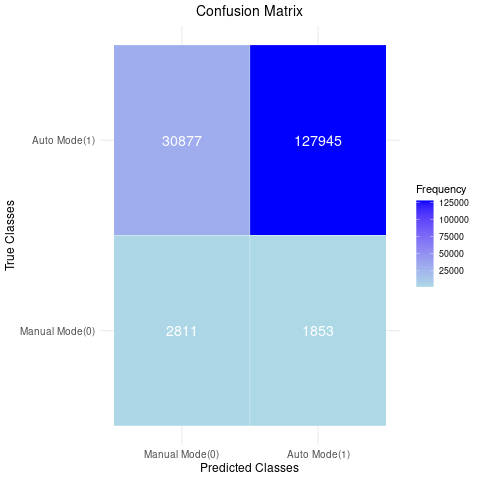

In [11]:
%%R
# Load required libraries
library(ggplot2)
library(caret)

# Map the values to labels (1 -> "Auto_mode", 0 -> "Manual")
predicted_classes_labeled <- factor(predicted_classes, levels = c(0,1), labels = c("Manual Mode(0)", "Auto Mode(1)"))
actual_classes_labeled <- factor (test_data$binaryDrivingMode, levels = c(0,1), labels = c("Manual Mode(0)", "Auto Mode(1)"))

# Generate the confusion matrix
cm <- confusionMatrix(predicted_classes_labeled, actual_classes_labeled)
cm_table <- as.data.frame(cm$table)

# Rename columns for better understanding
colnames(cm_table) <- c("Actual", "Predicted", "Frequency")

# Create the colored confusion matrix plot
ggplot(cm_table, aes(x = Predicted, y = Actual, fill = Frequency)) +
  geom_tile(color = "white") +
  scale_fill_gradient(low = "lightblue", high = "blue", name = "Frequency") +
  geom_text(aes(label = Frequency), color = "white", size = 5) +
  labs(title = "Confusion Matrix", x = "Predicted Classes", y = "True Classes") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, size = 14),
        axis.title = element_text(size = 12),
        axis.text = element_text(size = 10))

Area under the curve: 0.6284


Setting levels: control = 0, case = 1
Setting direction: controls < cases


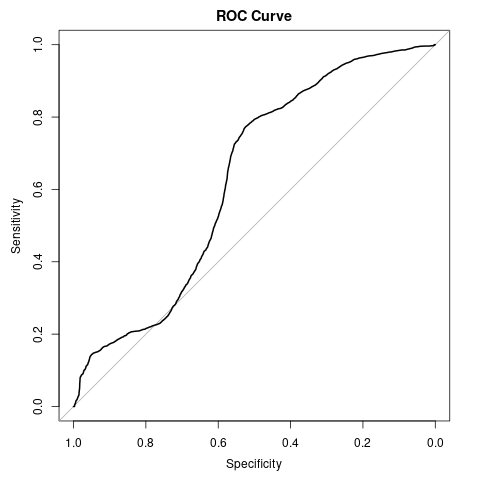

In [12]:
%%R

library(pROC)
roc_obj <- roc(test_data$binaryDrivingMode, predictions)
plot(roc_obj, main = "ROC Curve")
auc(roc_obj)

In [14]:
%%R

#Manually calculating the confusion matrix values
TP <- 127945
FP <- 1853
FN <- 30877
TN <- 2811

# Calculate Metrics
accuracy <- (TP + TN) / (TP + TN + FP + FN)
precision <- TP / (TP + FP)
recall <- TP / (TP + FN)

#Print Metrics
cat("Accuracy:", accuracy, "\n")
cat("Precision:", precision, "\n")
cat("Recall:", recall, "\n")

Accuracy: 0.7997994 
Precision: 0.985724 
Recall: 0.8055874 


In [16]:
%%R
#Filter the dataset for Complete Auto Drive predictions

#Defining the 10 gmIDs am working with
selected_gmIDs <- c(
   '5774dcde-f196-11ee-babe-fb353e7798cd','1c74d294-f1e4-11ee-baf0-fb353e7798cd','0f3cdf60-f1f6-11ee-bb00-fb353e7798cd','8b0593cc-cb4e-11ee-909c-e1dc60cf66f9',
'a6539bd2-cb72-11ee-909c-e1dc60cf66f9'
)


complete_auto_drive <- df_merged %>%
                                      
    filter(binaryDrivingMode == 1 & groupMetadataID.x %in% selected_gmIDs)

# Extract latitude and longitude
latitude_list <- complete_auto_drive$latitude
longitude_list <- complete_auto_drive$longitude


#  Save Latitutde and Longitude Lists
write.csv(latitude_list, "latitude_list.csv", row.names = FALSE)
write.csv(longitude_list, "longitude_list.csv", row.names = FALSE)

print("Latitude and Longitude lists saved successfully.")

[1] "Latitude and Longitude lists saved successfully."


In [17]:
%%R
latitude_data <- read.csv("latitude_list.csv")
longitude_data <- read.csv("longitude_list.csv")

head(latitude_data)

        x
1 39.3254
2 39.3254
3 39.3254
4 39.3254
5 39.3254
6 39.3254


In [18]:
%%R
head(longitude_data)

          x
1 -82.43594
2 -82.43594
3 -82.43594
4 -82.43594
5 -82.43594
6 -82.43594
